![](./images/header.png)

# 1. Introduction

In this notebook, we'll start from a time series of Sentinel-2 data, as well as a in-situ database of crop types in Malawi to train a crop type mapping algorithm.

By using the prior knowledge obtained from the previous exercise, we will preprocess the data, extract the data at our in-situ data locations, perform feature extraction and train a Random Forest Classifier.

First, let's explore the in-situ data.

# 2. Explore the in-situ data

By loading our in-situ dataframe, we can assess the variety of the dataset, as well as the location of the fields.


To start, load the in-situ dataset and visualize the amount and variety of training samples.

In [1]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
inpath = Path('/data/users/Public/couchard/Malawi_normalized_data_2023.gpkg')
croptype_df = gpd.read_file(inpath, driver='GPKG')

# Let's visualize the variety of training samples
print(f'Number of points: {len(croptype_df)}')

# Visualize the first few rows
croptype_df.head()

Number of points: 287


,ID,_submissio,sampleID,validityTi,croptype,geometry
0,358643135,2022-11-08,2023_MWI_FRT_POLY_110-15,2022-11-08,soy_soybeans,"POLYGON ((33.82151 -12.91549, 33.82150 -12.915..."
1,358643166,2022-11-08,2023_MWI_FRT_POLY_110-16,2022-11-08,maize,"POLYGON ((33.82303 -12.91504, 33.82270 -12.914..."
2,358643184,2022-11-08,2023_MWI_FRT_POLY_110-17,2022-11-08,maize,"POLYGON ((33.82393 -12.91475, 33.82410 -12.915..."
3,358643197,2022-11-08,2023_MWI_FRT_POLY_110-18,2022-11-08,Mixture three or more,"POLYGON ((33.82384 -12.91675, 33.82346 -12.916..."
4,358643220,2022-11-08,2023_MWI_FRT_POLY_110-19,2022-11-08,Mixture three or more,"POLYGON ((33.82240 -12.91415, 33.82186 -12.913..."


Text(0.5, 0, 'Occurences per crop type in in-situ data')

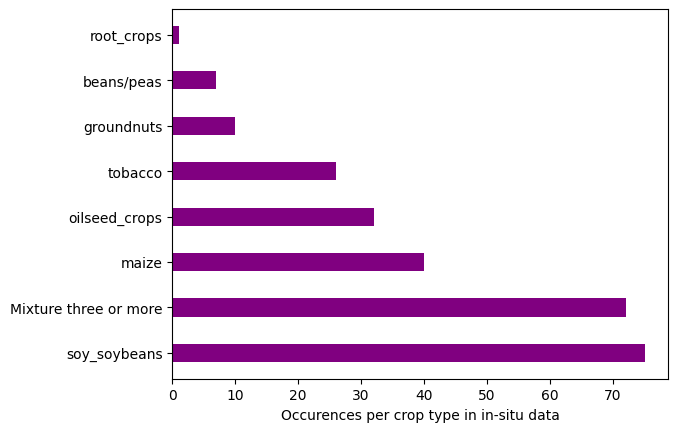

In [3]:
# The dataset has two column assigning crop type to the parcel: 'Crop grows' and 'CT_fin'
# Let's use the CT_fin column to choose the data
value_counts = croptype_df['croptype'].value_counts()

# We create a color map for our plot
fig = plt.barh(value_counts.index, value_counts.values, color='purple', height=0.4)
plt.xlabel('Occurences per crop type in in-situ data')

We can see that there is healthy amount of samples for Soy beans, Three crops and Maize. The other croptypes are too scarse in amount of points. When there are not enough data samples, it can be difficult to train a classifier, we will therefore only consider the first 3 most dominant crop types, other croptypes are moved to a "Other" class.

In [4]:
# Takes the 3 most common crop types in the data
croptypes = list(value_counts.sort_values(ascending=False).index)[:3]

def filter_value(val: str) -> str:
    if val in croptypes:
        return val
    else:
        return 'Other'

croptype_df['croptype'] = croptype_df.croptype.apply(filter_value)
croptype_df.head()

,ID,_submissio,sampleID,validityTi,croptype,geometry
0,358643135,2022-11-08,2023_MWI_FRT_POLY_110-15,2022-11-08,soy_soybeans,"POLYGON ((33.82151 -12.91549, 33.82150 -12.915..."
1,358643166,2022-11-08,2023_MWI_FRT_POLY_110-16,2022-11-08,maize,"POLYGON ((33.82303 -12.91504, 33.82270 -12.914..."
2,358643184,2022-11-08,2023_MWI_FRT_POLY_110-17,2022-11-08,maize,"POLYGON ((33.82393 -12.91475, 33.82410 -12.915..."
3,358643197,2022-11-08,2023_MWI_FRT_POLY_110-18,2022-11-08,Mixture three or more,"POLYGON ((33.82384 -12.91675, 33.82346 -12.916..."
4,358643220,2022-11-08,2023_MWI_FRT_POLY_110-19,2022-11-08,Mixture three or more,"POLYGON ((33.82240 -12.91415, 33.82186 -12.913..."


Now that you we have our filterered dataset, evaluate the bounding box of the points.

Using GeoPandas plotting functionalities, create an bounding box enveloping the entirety of our training dataset. To give it a comparison, plot it against the country of Malawi.

Documnetation for those functionalities is available here:
https://geopandas.org/en/stable/docs/user_guide/mapping.html

/tmp/ipykernel_29311/2407674233.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  country_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Text(0.5, 36.72222222222221, 'Malawi (pink) and the region of the training data (blue)')

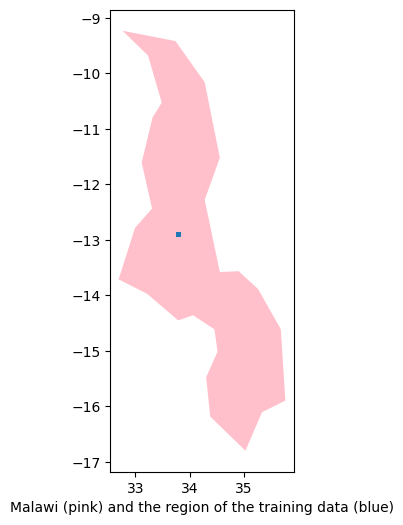

In [5]:
# Loads a dataset containing all the countries borders, and search for Malawi
country_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
malawi = country_df[country_df.name == 'Malawi']

# Compute the envelope
west, south, east, north = croptype_df.total_bounds
from shapely.geometry import box
bounds_df = gpd.GeoDataFrame(geometry=[box(west, south, east, north)], crs=country_df.crs)

# Show the country borders and the envelope
base = malawi.plot(color='pink', figsize=(12, 6))
bounds_df.plot(ax=base)
base.set_xlabel('Malawi (pink) and the region of the training data (blue)')

In [6]:
# Load the data
import openeo
from shapely.geometry import mapping
from pathlib import Path

out_path = Path('/data/users/Public/couchard/S2_L2A_Malawi.nc')

if not out_path.exists():
    spatial_extent = mapping(box(west, south, east, north))
    spatial_extent['crs'] = 'EPSG:4326'
    temporal_extent = ['2021-10-01', '2022-08-01']
    bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12', 'SCL']
    connection = openeo.connect('http://openeo.vito.be').authenticate_oidc()

    # Load the S2 collection
    cube = connection.load_collection(
        'SENTINEL2_L2A',
        spatial_extent=spatial_extent,
        temporal_extent=temporal_extent,
        bands=bands
    )

    job_options = {
        'sentinel-hub': {
            'client-alias': 'ai4food'
        },
    }

    job = cube.create_job(
        out_format='NetCDF', title='Malawi S2 extraction', job_options=job_options
    )

    job.start_and_wait()

    results = job.get_results()
    for asset in results.get_assets():
        if asset.metadata['type'].startswith('application/x-netcdf'):
            asset.download(out_path)

In [7]:
import rioxarray

out_path_10m = '/data/users/Public/couchard/S2_L2A_Malawi_10m.nc'
out_path_20m = '/data/users/Public/couchard/S2_L2A_Malawi_20m.nc'

# Split the data in 20m and 10m
inds = rioxarray.open_rasterio(out_path)
inds.attrs.update({'bounds': inds.rio.bounds()})

inds = inds.rename({'t': 'timestamp'})

inds_20m = inds[['B05', 'B06', 'B07', 'B11', 'B12']]
inds_20m.attrs.update({'resolution': 20.0})
inds_20m['SCENECLASSIFICATION'] = inds['SCL']

inds_10m = inds[['B02', 'B03', 'B04', 'B08']]
inds_10m.attrs.update({'resolution': 10.0})

inds_10m.to_netcdf(out_path_10m)
inds_20m.to_netcdf(out_path_20m)

# 3. Load and preprocess the training data

Using the same Sentinel-2 pre-processing piepeline used in the previous exercise, load the data and perform the same pre-processing operations.

* Compute the cloud mask from the 'SCENECLASSIFICATION' layer.
* Load the 20-m array, mask the clouds, perform 10-daily temporal compositing and linear interpolation.
* Using the same cloud mask, do the same cloud masking, temporal compositing and interpolation with the 10-m array.

No need to upsample the 20-m array.

In [8]:
# Import the necessary python libraries...
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# import custom python functions all defined in separate .py files
# custom functions
from mask import mask_ts
from composite import composite_ts
from interpolate import interpolate_ts

In [9]:
# We start by loading the scene classification layer, containing information about the presence of clouds
# This is delivered at 20m resolution, so we open the 20m resolution file
# infile = '/data/users/Private/jeroendegerickx/eoafrica/exercise_parcel_monitoring/s2_data/36LWL/30/S2-L2A_20m_36LWL-30_32736_2022-10-01_2023-08-01.nc'
infile_20m = '/data/users/Public/couchard/S2_L2A_Malawi_20m.nc'
infile_10m = '/data/users/Public/couchard/S2_L2A_Malawi_10m.nc'

ds = xr.open_dataset(infile_20m)

scl_20 = ds[['SCENECLASSIFICATION']].to_array()
scl_mask_values = [1, 3, 8, 9, 10, 11]
mask_20 = np.logical_not(scl_20.isin(scl_mask_values))

mask_20.attrs = scl_20.attrs.copy()


ts_20 = ds[['B05', 'B06', 'B07', 'B11', 'B12']].to_array()
ts_20_masked = mask_ts(ts_20, mask_20)

# Compoisiting interpolating and upsampling to 10-m resolution
ts_20_comp = composite_ts(ts_20_masked, freq=10, window=20, mode='median')
ts_20_fin = interpolate_ts(ts_20_comp)


In [10]:
ds = xr.open_dataset(infile_10m)

# convert the mask to 10 m resolution
# Get the 10 m bands from the file
ts_10 = ds[['B02', 'B03', 'B04', 'B08']].to_array()

# Apply the mask to the data
ts_10_masked = mask_ts(ts_10, mask_20)

# Apply temporal compositing
ts_10_fin = composite_ts(ts_10_masked, freq=10, window=20, mode='median')


Compute the NDVI value, as done in the previous exercise.

Then, using the <b>xr.concat(...)</b> function, assemble the two preprocessed arrays and the NDVI into a single array.

Docs: https://docs.xarray.dev/en/stable/user-guide/combining.html#concatenate

In [11]:
ts_fin = xr.concat([ts_10_fin, ts_20_fin], dim='variable')

ts_B08 = ts_fin.sel(variable='B08')
ts_B04 = ts_fin.sel(variable='B04')
ndvi = (ts_B08 - ts_B04) / (ts_B08 + ts_B04)

ts_fin = xr.concat([ts_fin, ndvi.expand_dims(dim='variable', axis=0).assign_coords({'variable': ['NDVI']})], dim='variable')
ts_fin

<xarray.DataArray (variable: 10, timestamp: 28, y: 907, x: 985)>
array([[[[9.66000000e+02, 9.47000000e+02, 9.24500000e+02, ...,
          8.66000000e+02, 8.59000000e+02, 8.16000000e+02],
         [9.30000000e+02, 9.53500000e+02, 9.29500000e+02, ...,
          9.61000000e+02, 8.05000000e+02, 7.97000000e+02],
         [8.67000000e+02, 9.35500000e+02, 8.85000000e+02, ...,
          9.21000000e+02, 7.93000000e+02, 8.22000000e+02],
         ...,
         [1.02700000e+03, 1.03950000e+03, 9.85500000e+02, ...,
          8.84000000e+02, 8.79500000e+02, 8.71500000e+02],
         [1.01750000e+03, 9.90000000e+02, 9.54500000e+02, ...,
          8.40000000e+02, 8.47500000e+02, 8.56500000e+02],
         [9.26000000e+02, 9.54000000e+02, 9.76500000e+02, ...,
          8.53000000e+02, 8.45500000e+02, 8.27000000e+02]],

        [[8.82500000e+02, 8.81000000e+02, 8.19500000e+02, ...,
          7.98500000e+02, 7.88000000e+02, 7.50500000e+02],
         [8.18000000e+02, 8.47500000e+02, 8.21000000e+02, ...,
          8.58500000e+02, 7.69500000e+02, 7.31500000e+02],
         [7.31500000e+02, 8.16000000e+02, 8.03000000e+02, ...,
          8.43500000e+02, 7.53000000e+02, 7.51500000e+02],
...
          2.68015176e-01, 2.65306115e-01, 2.63783783e-01],
         [           nan,            nan,            nan, ...,
          2.51305848e-01, 2.44565219e-01, 2.60188073e-01],
         [           nan,            nan,            nan, ...,
          2.33968809e-01, 2.24119529e-01, 2.38143295e-01]],

        [[3.08097273e-01, 3.22643340e-01, 3.20681274e-01, ...,
          3.77178550e-01, 3.42995167e-01, 4.12066758e-01],
         [3.89879525e-01, 3.49397600e-01, 3.43537420e-01, ...,
          3.28964621e-01, 3.48897547e-01, 3.32023561e-01],
         [4.91430759e-01, 3.50173354e-01, 3.73400927e-01, ...,
          3.54140133e-01, 3.81707311e-01, 3.22580636e-01],
         ...,
         [2.31703609e-01, 2.51184821e-01, 3.21309924e-01, ...,
          2.77493596e-01, 2.71428585e-01, 2.60471195e-01],
         [2.46696040e-01, 3.00928444e-01, 3.52053136e-01, ...,
          2.94697911e-01, 2.59306818e-01, 2.61179507e-01],
         [2.25308642e-01, 2.60829479e-01, 2.77955264e-01, ...,
          2.54807681e-01, 2.34068632e-01, 2.36612707e-01]]]],
      dtype=float32)
Coordinates:
  * variable   (variable) object 'B02' 'B03' 'B04' 'B08' ... 'B11' 'B12' 'NDVI'
  * timestamp  (timestamp) datetime64[ns] 2021-10-15 2021-10-25 ... 2022-07-12
  * y          (y) float64 8.578e+06 8.578e+06 8.578e+06 ... 8.569e+06 8.569e+06
  * x          (x) float64 5.82e+05 5.82e+05 5.82e+05 ... 5.918e+05 5.919e+05
Attributes:
    Conventions:  CF-1.9
    description:  
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    title:        
    bounds:       [ 582010. 8569130.  591860. 8578200.]
    resolution:   10.0

In [12]:
del ts_10_fin, ts_20_fin, ts_B04, ts_B08, ndvi, ts_10_masked, ts_20_masked, ts_10, ts_20, ds

# 4. Train a crop type classifier using Machine Learning.

In order to create a crop type map in malawi, we first need to train a Random Forest Classifier with the in-situ data we have available.

In this section, you will have to:

* Sample points within the training data we have at our disposition
* For every point, combine the variable and temporal dimension in to a single dimension using quentiles/percentiles.
* Train de model, evaluate its performance and perform full-tile inference.

### Sample random points from the GeoPandas dataset

From the GeoPandas dataset of croptypes constructed previously in this exercise, sample random points using the `geopandas.GeoSeries.sample_points` function.

Then, sample those points from the array that we just assembled

Docs: https://geopandas.org/en/stable/docs/user_guide/sampling.html

<AxesSubplot:>

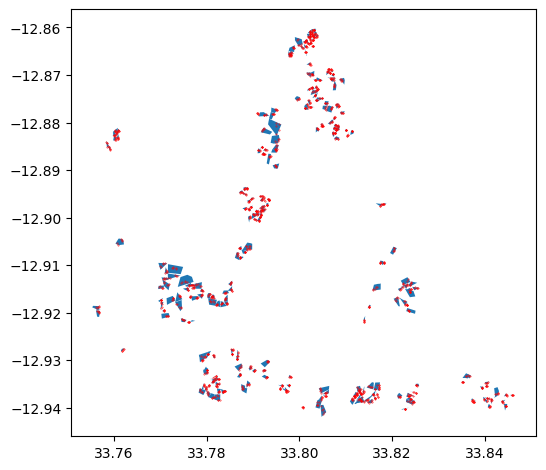

In [13]:
POINTS_PER_FIELD = 5

sampled_points = croptype_df.geometry.sample_points(POINTS_PER_FIELD, rng=42, method='cluster_poisson')
point_labels = croptype_df.croptype.repeat(POINTS_PER_FIELD)

fig, axis = plt.subplots(1, 1, figsize=(6, 6))
croptype_df.plot(ax=axis, legend=True)
sampled_points.plot(ax=axis, c='red', markersize=0.1)

Converting the extracted points to two list of lat and lon coordinates, and add points that are outside the fields

In [14]:
import random

points_x, points_y = [], []

for points in sampled_points:
    for point in points.geoms:
        points_x.append(point.x)
        points_y.append(point.y)

field_samples = len(points_x)
print(f'Points before adding nonfield: {len(points_x)}')

Points before adding nonfield: 1435


Extract the sample points from the array using `xarray.DataArray.sel` function

Docs: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.sel.html

In [15]:
from pyproj import Transformer
from rasterio import CRS

transformer = Transformer.from_crs(
    CRS.from_epsg(4326),
    CRS.from_epsg(32736),
    always_xy=True
)
points_data = []
for pt_x, pt_y in zip(points_x, points_y):
    pt_x, py_y = transformer.transform(pt_x, pt_y)
    point_data = ts_fin.sel(x=pt_x, y=pt_y, method='nearest')
    points_data.append(point_data)

training_data = xr.concat(points_data, dim='sample').assign_coords({'sample': list(range(0, len(points_x)))}).drop_vars(['x', 'y'])
training_data

<xarray.DataArray (sample: 1435, variable: 10, timestamp: 28)>
array([[[6.75000000e+02, 8.21000000e+02, 8.24000000e+02, ...,
         5.38000000e+02, 1.02150000e+03, 7.45000000e+02],
        [8.72500000e+02, 1.19800000e+03, 1.23400000e+03, ...,
         8.07000000e+02, 1.14850000e+03, 9.34000000e+02],
        [1.29500000e+03, 2.07400000e+03, 2.13200000e+03, ...,
         1.33200000e+03, 1.47000000e+03, 1.44800000e+03],
        ...,
        [2.69500000e+03, 4.43300000e+03, 4.46100000e+03, ...,
         3.40600000e+03, 3.00450000e+03, 3.68200000e+03],
        [2.11550000e+03, 3.57100000e+03, 3.68700000e+03, ...,
         2.50200000e+03, 2.20250000e+03, 2.98300000e+03],
        [1.20244563e-01, 1.09871246e-01, 1.12775698e-01, ...,
         2.68935233e-01, 1.73925266e-01, 1.86973616e-01]],

       [[6.45500000e+02, 8.21000000e+02, 8.30000000e+02, ...,
         5.20000000e+02, 9.34000000e+02, 6.74000000e+02],
        [8.53500000e+02, 1.15600000e+03, 1.21600000e+03, ...,
         8.13000000e+02, 1.04400000e+03, 9.26000000e+02],
        [1.24900000e+03, 2.01400000e+03, 2.07400000e+03, ...,
         1.27400000e+03, 1.37750000e+03, 1.43400000e+03],
...
        [4.26350000e+03, 4.30400000e+03, 4.34400000e+03, ...,
         2.87600000e+03, 3.07575000e+03, 3.27550000e+03],
        [3.68450000e+03, 3.68600000e+03, 3.96100000e+03, ...,
         2.17500000e+03, 2.40525000e+03, 2.63550000e+03],
        [1.70518741e-01, 1.72962233e-01, 1.70068026e-01, ...,
         4.22985792e-01,            nan, 3.03096652e-01]],

       [[9.73500000e+02, 1.01800000e+03, 1.02200000e+03, ...,
         5.25000000e+02,            nan, 7.01000000e+02],
        [1.27800000e+03, 1.31600000e+03, 1.32600000e+03, ...,
         8.52000000e+02,            nan, 9.35000000e+02],
        [1.65000000e+03, 1.70000000e+03, 1.74200000e+03, ...,
         8.92000000e+02,            nan, 1.17200000e+03],
        ...,
        [4.04400000e+03, 4.14400000e+03, 4.25400000e+03, ...,
         2.68500000e+03, 2.87200000e+03, 3.05900000e+03],
        [3.69550000e+03, 3.72200000e+03, 3.87700000e+03, ...,
         1.83000000e+03, 2.07625000e+03, 2.32250000e+03],
        [1.65402129e-01, 1.73553720e-01, 1.64908916e-01, ...,
         5.05817175e-01,            nan, 3.30859274e-01]]], dtype=float32)
Coordinates:
  * variable   (variable) object 'B02' 'B03' 'B04' 'B08' ... 'B11' 'B12' 'NDVI'
  * timestamp  (timestamp) datetime64[ns] 2021-10-15 2021-10-25 ... 2022-07-12
  * sample     (sample) int64 0 1 2 3 4 5 6 ... 1429 1430 1431 1432 1433 1434
Attributes:
    Conventions:  CF-1.9
    description:  
    institution:  openEO platform - Geotrellis backend: 0.16.2a1
    title:        
    bounds:       [ 582010. 8569130.  591860. 8578200.]
    resolution:   10.0

### Compute additional features using percentiles

One of the most interesting aspect of Remote Sensing when using Machine Learning is the temporal dimension. Different objects visible on the surface of earth will have a different evolution of with time. The most notable examples are the vegetation, that have seasonal properties depending on the region and the species and can therefore be classified when looking at the temporal dimension. Recent research push Deep Learning techniques to analyse those temporal characteristics and use the most of it.

Unfortunately, analyzing the temporal dimension obviously implies the use of another dimension, increasing tremendously the computational power requirements. This does not help the realization of large Remote Sensing projects, which already suffer from the very large quantities of data to process.

There is a large variety of techniques that can be used to mitigate the issue by combining the `variable` and the `time` dimensions into one. Here, we will use percentiles/quantiles computed on the `time` dimension. 

Using the `xarray.DataArray.quantile` function, we extract the following percentiles:

* For the Red, Green, Blue and NIR bands, we compute the 10th, 50th and 90th percentiles.
* For the NDVI, we compute the 10th, 25th, 50th, 75th and 90th percentiles.
* For the other bands, we only keep the 50th percentile (median)

In [16]:
rgbnir_quantiles = training_data.sel(variable=['B02', 'B03', 'B04', 'B08']).quantile([0.1, 0.5, 0.9], dim='timestamp')
rgbnir_quantiles_coords = [
    f'{first.item()}-{second.item()}'
    for first in rgbnir_quantiles.coords['variable']
    for second in rgbnir_quantiles.coords['quantile'] 
]
rgbnir_quantiles = rgbnir_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': rgbnir_quantiles_coords})

ndvi_quantiles = training_data.sel(variable=['NDVI']).quantile([0.1, 0.25, 0.5, 0.75, 0.9], dim='timestamp')
ndvi_quantiles_coords = [
    f'{first.item()}-{second.item()}'
    for first in ndvi_quantiles.coords['variable']
    for second in ndvi_quantiles.coords['quantile'] 
]
ndvi_quantiles = ndvi_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': ndvi_quantiles_coords})

other_quantiles = training_data.sel(variable=['B05', 'B06', 'B07', 'B11', 'B12']).quantile([0.5], dim='timestamp')
other_quantiles_coords = [
    f'{first.item()}-{second.item()}'
    for first in other_quantiles.coords['variable']
    for second in other_quantiles.coords['quantile'] 
]
other_quantiles = other_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': other_quantiles_coords})

training_data_df = xr.concat([rgbnir_quantiles, ndvi_quantiles, other_quantiles], dim='features').to_dataframe(name='malawi-training-data', dim_order=['sample', 'features']).unstack()
training_data_df

malawi-training-data                                            \
features              B02-0.1 B02-0.5  B02-0.9 B03-0.1  B03-0.5 B03-0.9   
sample                                                                    
0                       371.1  662.50   834.35   582.7   912.75  1231.0   
1                       374.2  660.00   829.50   566.5   958.50  1216.0   
2                       264.2  765.50   887.45   449.9  1029.00  1294.5   
3                       268.0  767.75  1063.00   499.0  1057.00  1579.7   
4                       318.2  784.25  1056.30   468.7  1073.00  1595.9   
...                       ...     ...      ...     ...      ...     ...   
1430                    429.6  947.25  1225.70   733.3  1265.50  1588.2   
1431                    452.0  971.00  1060.00   728.0  1188.00  1419.6   
1432                    484.8  904.00  1029.20   781.0  1216.00  1388.4   
1433                    484.8  904.00  1029.20   781.0  1216.00  1388.4   
1434                    536.2  816.00  1064.40   873.6  1202.00  1469.6   

                                          ...                                \
features B04-0.1 B04-0.5 B04-0.9 B08-0.1  ...  NDVI-0.1 NDVI-0.25  NDVI-0.5   
sample                                    ...                                 
0          557.0  1330.0  2129.7  1949.5  ...  0.088636  0.105266  0.227954   
1          632.0  1274.0  2085.7  1893.2  ...  0.094740  0.118780  0.240840   
2          538.0  1343.5  2155.5  1935.4  ...  0.095695  0.106557  0.220010   
3          579.5  1285.0  2197.9  2086.8  ...  0.091054  0.107123  0.258618   
4          654.0  1266.0  2185.3  2090.8  ...  0.091356  0.105860  0.254566   
...          ...     ...     ...     ...  ...       ...       ...       ...   
1430       652.8  1641.0  1946.9  2268.6  ...  0.160391  0.177692  0.211882   
1431       666.4  1246.0  1884.4  2258.0  ...  0.158578  0.168042  0.323561   
1432       799.7  1188.0  1830.0  2343.8  ...  0.160831  0.170293  0.303097   
1433       799.7  1188.0  1830.0  2343.8  ...  0.160831  0.170293  0.303097   
1434       831.2  1172.0  1827.6  2397.4  ...  0.165303  0.172267  0.330859   

                                                                       \
features NDVI-0.75  NDVI-0.9   B05-0.5  B06-0.5  B07-0.5      B11-0.5   
sample                                                                  
0         0.643880  0.701304  1601.250  2497.25  2664.25  2975.750000   
1         0.598776  0.734007  1684.500  2545.00  2662.50  3034.416626   
2         0.553688  0.646766  1575.000  2540.00  2815.75  3221.750000   
3         0.575454  0.761351  1667.000  2565.50  3031.25  3307.250000   
4         0.549396  0.730753  1758.250  2567.50  2707.25  3211.000000   
...            ...       ...       ...      ...      ...          ...   
1430      0.473786  0.636336  1538.125  2483.00  2760.25  3147.500000   
1431      0.473049  0.630815  1673.750  2480.50  2738.75  3224.250000   
1432      0.477439  0.594879  1673.750  2480.50  2738.75  3224.250000   
1433      0.477439  0.594879  1673.750  2480.50  2738.75  3224.250000   
1434      0.523719  0.588768  1589.000  2501.25  2767.00  2749.000000   

                       
features      B12-0.5  
sample                 
0         1992.583313  
1         2064.000000  
2         2202.000000  
3         2185.750000  
4         2250.000000  
...               ...  
1430      2220.125000  
1431      2258.000000  
1432      2258.000000  
1433      2258.000000  
1434      1830.000000  

[1435 rows x 22 columns]

### AI Time 💃 Let's train a Random Forest Classifier

Using the sklearn framework, let's train a random forest classifier. Before fitting the data within our model, we still need to do a final step: separating the data in two sets: the <b>training</b> data and the <b>validation</b> data. In order to prove that the model generalizes well on new samples, we want to test the performance of our model on different data than the one that was used to train it.

This split can be easily done from our DataFrame using the `sklearn.model_selection.train_test_split` function.

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Once split, train the model

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from catboost import CatBoostClassifier

# Let's perform 
X_train, X_test, y_train, y_test = train_test_split(training_data_df, point_labels, test_size=0.20, shuffle=True, random_state=42)


model = CatBoostClassifier()

# We train our model
model.fit(X_train, y_train, logging_level='Silent')

### Evoluate model performance

To evaluate the model performance, we perform prediction on the validation data that we previously split from. Then, we can use the `sklearn.metrics.accuracy_score` and `sklearn.metrics.confusion_matrix` functions

Docs: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

0.662020905923345


([<matplotlib.axis.YTick at 0x7fa9c63e9550>,
 [Text(0, 0.5, 'Mixture three or more'),
  Text(0, 1.5, 'Other'),
  Text(0, 2.5, 'maize'),
  Text(0, 3.5, 'soy_soybeans')])

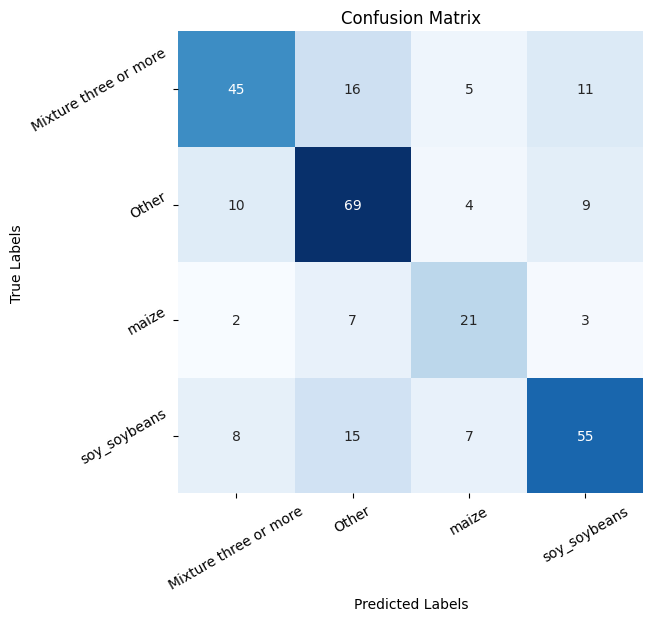

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# First, we predict the result the model on the validation data
y_pred = model.predict(X_test)

# Compute the accuracy score, the confusion matrix and the plot the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(accuracy)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set labels, title, and ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(cm)) + 0.5, labels=model.classes_, rotation=30)  # Replace labels with your class names
plt.yticks(np.arange(len(cm)) + 0.5, labels=model.classes_, rotation=30)  # Replace labels with your class names

### Perform inference for crop type mapping 🗺️

Now that our model is trained, let's perform inference on the entirety of our downloaded data.

First, compute the same quantiles as done for the training data, but this time on the entire data cube. Then combine those quantile cubes into a single one using the xr.concat method.

In [19]:
import dask
from dask.diagnostics.progress import ProgressBar
dask.config.set(scheduler='multiprocessing')

with ProgressBar():
    ts_fin = ts_fin.chunk({'x': 100, 'y': 100, 'timestamp': -1, 'variable': -1})

    rgbnir_quantiles = ts_fin.sel(variable=['B02', 'B03', 'B04', 'B08']).quantile([0.1, 0.5, 0.9], dim='timestamp')
    rgbnir_quantiles_coords = [
        f'{first.item()}-{second.item()}'
        for first in rgbnir_quantiles.coords['variable']
        for second in rgbnir_quantiles.coords['quantile'] 
    ]
    rgbnir_quantiles = rgbnir_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': rgbnir_quantiles_coords})

    ndvi_quantiles = ts_fin.sel(variable=['NDVI']).quantile([0.1, 0.25, 0.5, 0.75, 0.9], dim='timestamp')
    ndvi_quantiles_coords = [
        f'{first.item()}-{second.item()}'
        for first in ndvi_quantiles.coords['variable']
        for second in ndvi_quantiles.coords['quantile'] 
    ]
    ndvi_quantiles = ndvi_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': ndvi_quantiles_coords})

    other_quantiles = ts_fin.sel(variable=['B05', 'B06', 'B07', 'B11', 'B12']).quantile([0.5], dim='timestamp')
    other_quantiles_coords = [
        f'{first.item()}-{second.item()}'
        for first in other_quantiles.coords['variable']
        for second in other_quantiles.coords['quantile'] 
    ]
    other_quantiles = other_quantiles.stack(features=('variable', 'quantile')).drop(['variable', 'quantile']).assign_coords({'features': other_quantiles_coords})

    ts_fin_inference = xr.concat([rgbnir_quantiles, ndvi_quantiles, other_quantiles], dim='features').compute()

ts_fin_inference
#inference_df = ts_fin_inference.to_dataframe(name='malawi-training-data', dim_order=['sample', 'features']).unstack()

[########################################] | 100% Completed | 187.78 s


<xarray.DataArray (y: 907, x: 985, features: 22)>
array([[[ 524.        ,  739.75      , 1077.6       , ...,
         2563.        , 3105.125     , 2046.        ],
        [ 508.9       ,  742.75      , 1112.        , ...,
         2548.75      , 3069.        , 2177.        ],
        [ 526.9       ,  748.        , 1078.        , ...,
         2548.75      , 3069.        , 2177.        ],
        ...,
        [ 417.        ,  528.        ,  866.        , ...,
         2369.83337402, 3225.        , 2141.79162598],
        [ 436.5       ,  562.        ,  859.        , ...,
         2321.66662598, 3398.        , 2365.375     ],
        [ 455.5       ,  581.        ,  846.        , ...,
         2321.66662598, 3398.        , 2365.375     ]],

       [[ 502.        ,  688.        , 1080.        , ...,
         2563.        , 3105.125     , 2046.        ],
        [ 509.6       ,  721.5       , 1092.        , ...,
         2548.75      , 3069.        , 2177.        ],
        [ 528.9       ,  701.        , 1080.        , ...,
         2548.75      , 3069.        , 2177.        ],
...
        [ 438.        ,  819.5       ,  959.        , ...,
         2877.75      , 3045.        , 2208.        ],
        [ 422.7       ,  802.        ,  976.8       , ...,
         2860.25      , 3038.        , 2142.5       ],
        [ 438.25      ,  852.5       ,  979.8       , ...,
         2860.25      , 3038.        , 2142.5       ]],

       [[ 443.        ,  796.5       ,  932.8       , ...,
         2146.75      , 3495.5       , 2519.5       ],
        [ 448.5       ,  778.5       , 1162.4       , ...,
         2146.2142334 , 3480.14282227, 2673.42858887],
        [ 454.        ,  798.25      , 1149.8       , ...,
         2146.2142334 , 3480.14282227, 2673.42858887],
        ...,
        [ 454.        ,  822.5       , 1022.9       , ...,
         2866.5       , 3253.        , 2261.        ],
        [ 458.        ,  791.        ,  982.3       , ...,
         2820.        , 3183.5       , 2211.        ],
        [ 439.05      ,  816.5       ,  977.7       , ...,
         2820.        , 3183.5       , 2211.        ]]])
Coordinates:
  * y         (y) float64 8.578e+06 8.578e+06 8.578e+06 ... 8.569e+06 8.569e+06
  * x         (x) float64 5.82e+05 5.82e+05 5.82e+05 ... 5.918e+05 5.919e+05
  * features  (features) <U9 'B02-0.1' 'B02-0.5' ... 'B11-0.5' 'B12-0.5'

In [20]:
inference_df = ts_fin_inference.to_dataframe(name='malawi-training-data', dim_order=['x', 'y', 'features']).unstack()
inference_df.head()

malawi-training-data                                   \
features                        B02-0.1 B02-0.5 B02-0.9 B03-0.1  B03-0.5   
x        y                                                                 
582015.0 8578195.0               524.00  739.75  1077.6   796.0  1022.75   
         8578185.0               502.00  688.00  1080.0   782.0   956.50   
         8578175.0               400.40  611.00  1049.8   690.0   835.25   
         8578165.0               380.90  657.50  1080.8   636.5   881.50   
         8578155.0               400.25  749.25  1143.0   709.9  1011.50   

                                                             ...            \
features           B03-0.9 B04-0.1  B04-0.5 B04-0.9 B08-0.1  ...  NDVI-0.1   
x        y                                                   ...             
582015.0 8578195.0  1368.0  905.60  1354.00  1564.1  1854.9  ...  0.148686   
         8578185.0  1429.8  822.30  1170.50  1433.3  1729.8  ...  0.193134   
         8578175.0  1334.0  642.00   955.75  1290.2  2046.2  ...  0.328520   
         8578165.0  1348.0  652.00   995.75  1350.5  2092.4  ...  0.293075   
         8578155.0  1410.0  655.35  1262.00  1535.6  1958.8  ...  0.174045   

                                                                         \
features           NDVI-0.25  NDVI-0.5 NDVI-0.75  NDVI-0.9      B05-0.5   
x        y                                                                
582015.0 8578195.0  0.156987  0.292651  0.435244  0.505476  1539.599976   
         8578185.0  0.201860  0.289730  0.506737  0.556391  1539.599976   
         8578175.0  0.342900  0.397782  0.632591  0.663794  1446.625000   
         8578165.0  0.310484  0.338582  0.609389  0.635077  1446.625000   
         8578155.0  0.207650  0.395929  0.639358  0.682243  1652.000000   

                                                            
features            B06-0.5   B07-0.5      B11-0.5 B12-0.5  
x        y                                                  
582015.0 8578195.0  2246.75  2563.000  3105.125000  2046.0  
         8578185.0  2246.75  2563.000  3105.125000  2046.0  
         8578175.0  2549.00  2769.000  2628.500000  1762.0  
         8578165.0  2549.00  2769.000  2628.500000  1762.0  
         8578155.0  2726.00  3186.125  2645.699951  1795.0  

[5 rows x 22 columns]

As done previously, transform the entire datacube into a single dataset, then perform model inference using the `model.predict` method.

In [21]:
prediction = model.predict(inference_df)
prediction

array([['Mixture three or more'],
       ['Mixture three or more'],
       ['Other'],
       ...,
       ['soy_soybeans'],
       ['Other'],
       ['soy_soybeans']], dtype=object)

### Map visualization 🔎

Let's reconstruct the map from the given prediction. Let's map every class to a tuple giving a color.

In [22]:
# Blue
OTHER_COLOR = (48, 110, 209)

# Yellow
MAIZE = (204, 164, 55)

# Purple
SOY_BEANS = (163, 5, 158)

# Green
TREE_MIXTURE = (26, 125, 9)

color_map = {
    'Mixture three or more': TREE_MIXTURE,
    'soy_soybeans': SOY_BEANS,
    'Other': OTHER_COLOR,
    'maize': MAIZE
}

def map_class_to_color(class_value: str):
    # Returns the color of the given class, and black color if unknown
    return color_map.get(class_value, (0, 0, 0))

vectorized_map = np.vectorize(map_class_to_color)

rgb_array = np.array(vectorized_map(prediction)).squeeze().reshape(
    3, ts_fin_inference.shape[1], ts_fin_inference.shape[0]
)

rgb_array = np.moveaxis(rgb_array, 0, -1)

prediction_array = xr.DataArray(
    rgb_array,
    dims=['x', 'y', 'channels'],
    coords={
        'x': ts_fin_inference.coords['x'],
        'y': ts_fin_inference.coords['y'],
        'channels': ['R', 'G', 'B']
    }
)

prediction_array.shape

(985, 907, 3)

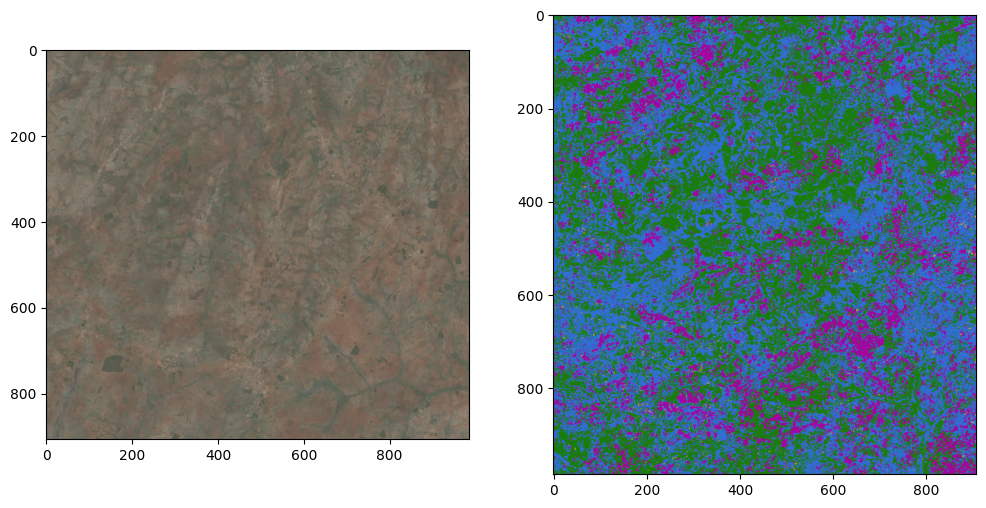

In [23]:
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))

rgb = (ts_fin_inference.sel(features=['B04-0.5', 'B03-0.5', 'B02-0.5']) / 1e4) ** .4

axis[0].imshow(rgb)
axis[1].imshow(rgb_array)